In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv("preprocessed_course_data.csv")

In [2]:
activity_cols = ['nevents', 'ndays_act', 'nchapters', 'nforum_posts']
outcome_cols = ['grade', 'certified']
correlation_cols = outcome_cols + activity_cols

# 강의 구분 ID
df['course_id'] = (
    df['university'].astype(str) + '_' +
    df['course_code'].astype(str) + '_' +
    df['year'].astype(str) + '_' +
    df['semester'].astype(str)
)

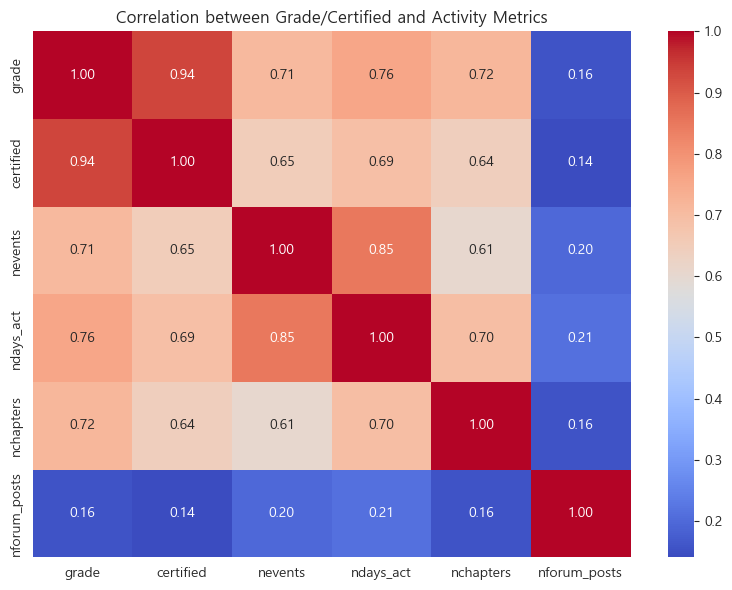

In [3]:
# 상관관계 히트맵을 위한 데이터 준비
corr_df = df[correlation_cols].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Grade/Certified and Activity Metrics")
plt.tight_layout()
plt.show()

In [4]:
# 강의별 수료율 계산
group_cols = ['university', 'course_code', 'year', 'semester', 'course_title']
certified_rate = (
    df.groupby(group_cols)['certified']
    .agg(['count', 'sum'])
    .rename(columns={'count': 'registered', 'sum': 'certified'})
    .assign(certified_rate=lambda x: x['certified'] / x['registered'] * 100)
    .reset_index()
)

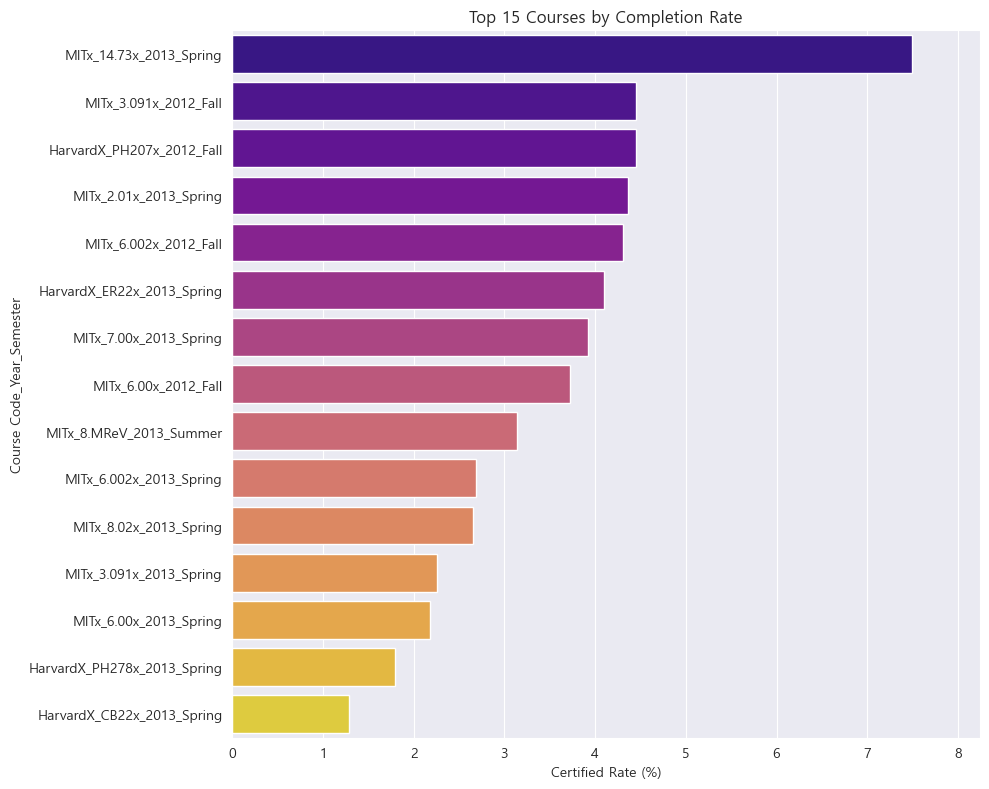

In [5]:
certified_rate['course_id'] = (
    certified_rate['university'].astype(str) + '_' +
    certified_rate['course_code'].astype(str) + '_' +
    certified_rate['year'].astype(str) + '_' +
    certified_rate['semester'].astype(str)
)

# 수료율 상위 15개 강의 정렬
top_courses = certified_rate.sort_values(by='certified_rate', ascending=False).head(15)

# 막대 차트 그리기
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_courses,
    x='certified_rate',
    y='course_id',
    palette='plasma',
    edgecolor=None
)
plt.xlabel('Certified Rate (%)')
plt.ylabel('Course Code_Year_Semester')
plt.title('Top 15 Courses by Completion Rate')
plt.xlim(0, top_courses['certified_rate'].max() * 1.1)
plt.tight_layout()
plt.show()

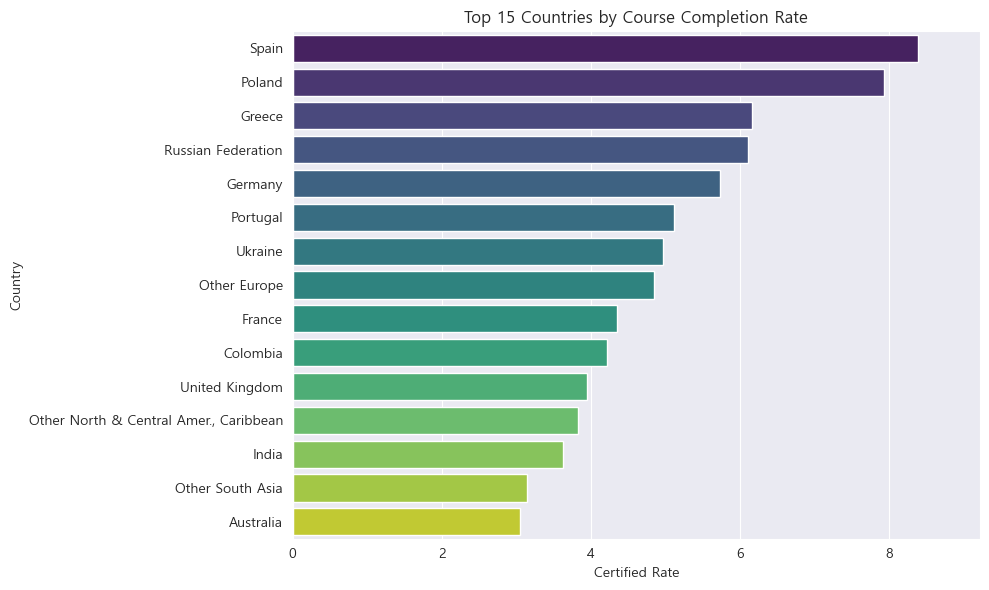

In [6]:
# 국가별 수료율 계산
country_certified_rate = (
    df.groupby('final_cc_cname_DI')['certified']
    .agg(['count', 'sum'])
    .rename(columns={'count': 'registered', 'sum': 'certified'})
    .assign(certified_rate=lambda x: x['certified'] / x['registered'] * 100)
    .reset_index()
    .sort_values(by='certified_rate', ascending=False)
)

# 상위 15개 국가만 시각화 (수료율 높은 순)
top_countries = country_certified_rate.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x='certified_rate', y='final_cc_cname_DI', palette='viridis')
plt.xlabel('Certified Rate')
plt.ylabel('Country')
plt.title('Top 15 Countries by Course Completion Rate')
plt.xlim(0, top_countries['certified_rate'].max() * 1.1)
plt.tight_layout()
plt.show()

In [7]:
# 필요한 컬럼만 로드
use_cols = [
    'university', 'course_code', 'year', 'semester', 'course_title',
    'grade', 'certified'
]

# 강의별 평균 성적과 난이도 계산
course_summary = (
    df.groupby('course_id')
    .agg(
        mean_grade=('grade', 'mean'),
        certified_rate=('certified', lambda x: x.sum() / x.count() * 100),
        course_title=('course_title', 'first'),
        university=('university', 'first'),
        course_code=('course_code', 'first'),
        count=('grade', 'count')
    )
    .assign(difficulty= lambda x: 1 - x['mean_grade'])
    .reset_index()
)

# 테이블로 정리
course_table = course_summary[['university', 'course_code', 'course_title', 'mean_grade', 'difficulty', 'certified_rate', 'count']]
course_table = course_table.sort_values(by='difficulty', ascending=False).reset_index(drop=True)
course_table

,university,course_code,course_title,mean_grade,difficulty,certified_rate,count
0,HarvardX,CS50x,Introduction to Computer Science,0.007672,0.992328,0.761669,167756
1,HarvardX,CB22x,The Ancient Greek Hero,0.016555,0.983445,1.282094,24406
2,HarvardX,PH278x,Human Health and Global Environmental Change,0.026637,0.973363,1.797815,32408
3,MITx,3.091x,Introduction to Solid State Chemistry,0.028963,0.971037,2.261554,5293
4,MITx,6.00x,Introduction to Computer Science and Programming,0.031591,0.968409,2.181103,50407
5,MITx,8.02x,Physics II: Electricity and Magnetism,0.032933,0.967067,2.658473,28707
6,MITx,6.002x,Circuits and Electronics,0.034526,0.965474,2.688733,17780
7,MITx,8.MReV,Mechanics ReView,0.041220,0.958780,3.141195,8755
8,MITx,6.00x,Introduction to Computer Science and Programming,0.041831,0.958169,3.718996,65280
9,MITx,7.00x,Introduction to Biology - The Secret of Life,0.045398,0.954602,3.920168,19666


In [8]:
# 유효한 study_days만 필터링
df_valid = df[df['study_days'].notna() & (df['study_days'] >= 0)].copy()

# 분위 경계값 구하기 후 중복 제거
quantiles = df_valid['study_days'].quantile([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]).values
unique_bins = np.unique(quantiles)  # 중복 제거

# 레이블 생성 (개수 맞추기)
label_base = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']
labels = label_base[:len(unique_bins)-1]  # 구간 수만큼 자르기

# 범위 포함된 레이블
bin_labels = [
    f"{labels[i]} ({int(unique_bins[i])}~{int(unique_bins[i+1])}일)"
    for i in range(len(labels))
]

# 수동 구간 라벨링
df_valid['study_days_level'] = pd.cut(
    df_valid['study_days'],
    bins=unique_bins,
    labels=bin_labels,
    include_lowest=True
)

# 그룹별 성과 요약
study_day_summary = (
    df_valid.groupby('study_days_level')
    .agg(
        mean_grade=('grade', 'mean'),
        certified_rate=('certified', lambda x: x.sum() / x.count() * 100),
        count=('grade', 'count')
    )
    .reset_index()
)

study_day_summary

,study_days_level,mean_grade,certified_rate,count
0,Very Short (0~4일),0.000884,0.025131,349787
1,Short (4~63일),0.017828,0.543970,114106
2,Medium (63~409일),0.147702,13.310024,118446


In [9]:
# 활동 지표 및 성적만 사용
cols = ['nevents', 'ndays_act', 'nchapters', 'nforum_posts', 'grade']
df_model = df[cols].dropna()

# 독립변수(X), 종속변수(y)
X = df_model[['nevents', 'ndays_act', 'nchapters', 'nforum_posts']]
y = df_model['grade']

# 스케일링 (정규화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# 회귀 계수 정리
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# 결과 요약
print(f'R2 Score: {r2}, RMSE: {rmse}')

R2 Score: 0.6459629861389083, RMSE: 0.12460569671526052


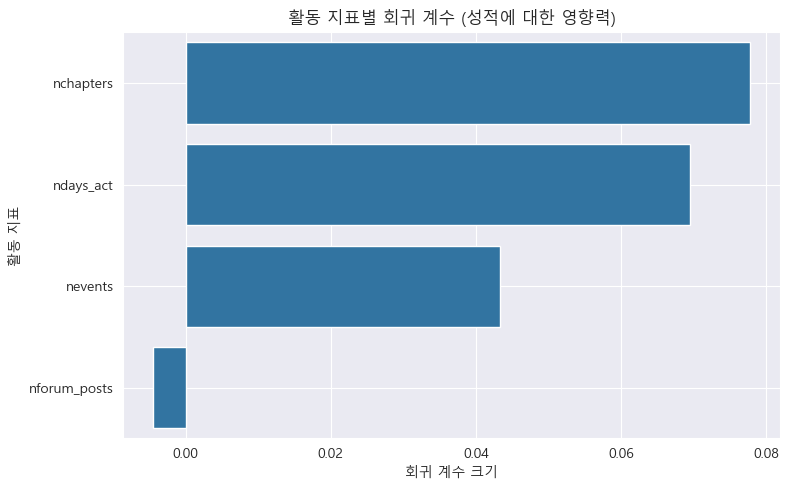

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', orient='h')
plt.title('활동 지표별 회귀 계수 (성적에 대한 영향력)')
plt.xlabel('회귀 계수 크기')
plt.ylabel('활동 지표')
plt.grid(True)
plt.tight_layout()
plt.show()

R² Score (0.65):
학습 활동 지표만으로 성적의 약 65%를 설명할 수 있음

RMSE (0.12):
예측된 성적과 실제 성적 사이의 평균 오차는 ±0.12 수준

중요한 활동 지표 순서 (성적에 영향 큰 순):
nchapters > ndays_act > nevents
→ 많은 챕터 학습과 꾸준한 참여일수가 성적 향상에 가장 효과적

In [11]:
# 독립변수, 종속변수 지정 (수료 여부 예측용)
X = df_model[['nevents', 'ndays_act', 'nchapters', 'nforum_posts']]
y = (df_model['grade'] > 0).astype(int)  # 수료 여부를 grade 기준으로 대체 (성적 > 0 → 수료)

# 정규화
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 학습
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# 예측 및 평가
y_pred_log = log_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_log)
conf_matrix = confusion_matrix(y_test, y_pred_log)
report = classification_report(y_test, y_pred_log, output_dict=True)

# 회귀 계수 정리
log_coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Logistic_Coefficient': log_model.coef_[0]
}).sort_values(by='Logistic_Coefficient', key=abs, ascending=False).reset_index(drop=True)

# 로지스틱 회귀 요약 출력 (print 기반)
print("[로지스틱 회귀 결과 요약]")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (수료=1): {report['1']['precision']:.4f}")
print(f"Recall (수료=1): {report['1']['recall']:.4f}")
print(f"F1-Score (수료=1): {report['1']['f1-score']:.4f}")
print()

# 회귀 계수 출력
print("[변수별 로지스틱 회귀 계수]")
for i, row in log_coef_df.iterrows():
    print(f"{row['Feature']:<15} : {row['Logistic_Coefficient']:.4f}")

[로지스틱 회귀 결과 요약]
Accuracy: 0.8868
Precision (수료=1): 0.8972
Recall (수료=1): 0.6442
F1-Score (수료=1): 0.7500

[변수별 로지스틱 회귀 계수]
nevents         : 7.4621
ndays_act       : 0.2431
nchapters       : 0.1997
nforum_posts    : 0.0693


Accuracy	0.8868	전체 예측 중 88.7%가 정확하게 맞음

Precision (1)	0.8972	수료자라고 예측한 사람 중 89.7%가 실제 수료자

Recall (1)	0.6442	실제 수료자 중 64.4%를 올바르게 찾아냄

F1-Score (1)	0.7500	Precision과 Recall의 균형을 반영한 종합 성능 지표

In [13]:
# 필요한 열만 불러오기
usecols = ['university', 'course_code', 'year', 'semester', 'course_title',
           'nevents', 'ndays_act', 'nchapters', 'nforum_posts']

# 강의별 활동량 평균 계산
activity_by_course = (
    df.groupby('course_id')
    .agg(
        nevents_avg=('nevents', 'mean'),
        ndays_act_avg=('ndays_act', 'mean'),
        nchapters_avg=('nchapters', 'mean'),
        nforum_posts_avg=('nforum_posts', 'mean'),
        student_count=('course_id', 'count'),
        certified_count=('certified', 'sum')
    )
    .reset_index()
    .sort_values(by='nevents_avg', ascending=False)
)

activity_by_course

,course_id,nevents_avg,ndays_act_avg,nchapters_avg,nforum_posts_avg,student_count,certified_count
14,MITx_8.02x_2013_Spring,677.206718,6.238415,3.964836,0.027911,30920,822
3,HarvardX_PH207x_2012_Fall,654.299851,5.987764,4.377272,0.020286,41407,1841
11,MITx_6.00x_2012_Fall,648.713959,6.798584,3.827044,0.040238,66604,2477
5,MITx_14.73x_2013_Spring,627.011038,5.493094,3.256046,0.012975,27823,2085
13,MITx_7.00x_2013_Spring,591.100505,6.462095,3.942237,0.077260,20994,823
15,MITx_8.MReV_2013_Summer,551.906612,4.467540,5.294214,0.014913,9455,297
7,MITx_3.091x_2012_Fall,547.770356,4.945373,3.597028,0.008664,14197,632
6,MITx_2.01x_2013_Spring,527.064081,6.216652,3.377378,0.015368,5661,247
12,MITx_6.00x_2013_Spring,520.767738,5.818770,3.406936,0.024596,57448,1253
9,MITx_6.002x_2012_Fall,506.834444,5.780522,4.055281,0.021459,40635,1749
